# Arbitrage strategy

We are getting decent live market data between differnt platforms, lets figure out how to arb it successfully

## Scenario

- Starting with $1000 of capital
- driving metric is apy (apy = spread / days to resolution * 365)
- reevaluate positions to sell when edge is gone
- find the best way to allocate entire portfolio each day

,Cheapest YES ($),Cheapest NO ($),Bundle Cost ($),Profit ($),Arbitrage?,APY (%)
0,0.11,0.864,0.974,0.026,YES,5.41


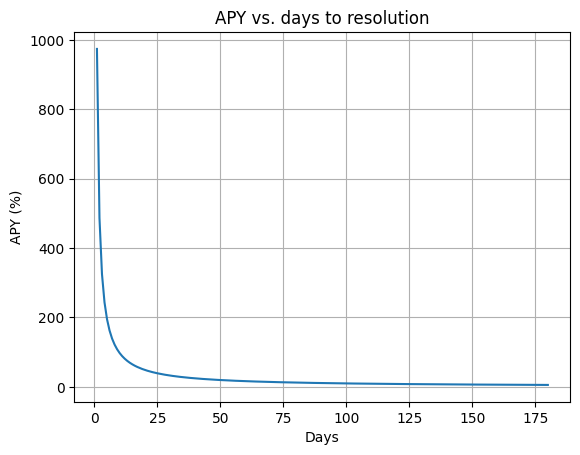

In [11]:
# ── Arbitrage Notebook: quick & dirty checker ──────────────────────────
import pandas as pd
import matplotlib.pyplot as plt

# EDIT THESE TWO LISTS ↴  (prices in **cents**)
priceA = [13.6, 86.4]   # [YES, NO] on Exchange A
priceB = [11, 90]   # [YES, NO] on Exchange B

# EDIT: days until the market resolves
days_to_resolution = 180   # e.g. 6 months

# ── Core calc ──────────────────────────────────────────────────────────
yes_cheapest = min(priceA[0], priceB[0]) / 100
no_cheapest  = min(priceA[1], priceB[1]) / 100
bundle_cost  = yes_cheapest + no_cheapest
profit       = 1 - bundle_cost            # $1 is the guaranteed payoff

apy = (profit / bundle_cost) * (365 / days_to_resolution) * 100 if bundle_cost < 1 else None

result = pd.DataFrame({
    "Cheapest YES ($)": [yes_cheapest],
    "Cheapest NO ($)":  [no_cheapest],
    "Bundle Cost ($)":  [bundle_cost],
    "Profit ($)":       [profit],
    "Arbitrage?":       ["YES" if profit > 0 else "NO"],
    "APY (%)":          [round(apy, 2) if apy is not None else "—"],
})

display(result)

# ── Visualise APY curve across 1…days_to_resolution ────────────────────
if profit > 0:                 # only worth plotting when arb exists
    days = list(range(1, days_to_resolution + 1))
    apy_curve = [(profit / bundle_cost) * (365 / d) * 100 for d in days]

    plt.figure()
    plt.plot(days, apy_curve)
    plt.title("APY vs. days to resolution")
    plt.xlabel("Days")
    plt.ylabel("APY (%)")
    plt.grid(True)
    plt.show()
else:
    print("No arb → bundle cost ≥ $1. Adjust prices and try again.")


In [12]:
# ── Position‑sizing helper ─────────────────────────────────────────────
capital = 100.0   # ← total bankroll to deploy in USD

# Identify which exchange had the cheapest legs
yes_exchange = "A" if yes_cheapest == priceA[0] / 100 else "B"
no_exchange  = "A" if no_cheapest  == priceA[1] / 100 else "B"

# How many complete “YES+NO” bundles can we buy?
bundles = int(capital // bundle_cost)

# Capital deployed per leg
yes_cost = bundles * yes_cheapest
no_cost  = bundles * no_cheapest

leftover = capital - (yes_cost + no_cost)

import pandas as pd
position = pd.DataFrame({
    "Leg":      ["YES", "NO"],
    "Exchange": [yes_exchange, no_exchange],
    "Contracts": [bundles, bundles],
    "Cost ($)": [round(yes_cost, 2), round(no_cost, 2)],
})

print("Allocation for $100 capital", position)

print(f"\nTotal bundles bought: {bundles}")
print(f"Total capital used : ${yes_cost + no_cost:.2f}")
print(f"Leftover cash      : ${leftover:.2f}")


Allocation for $100 capital    Leg Exchange  Contracts  Cost ($)
0  YES        B        102     11.22
1   NO        A        102     88.13

Total bundles bought: 102
Total capital used : $99.35
Leftover cash      : $0.65


In [13]:
# ── QUICK ARB SIZER ───────────────────────────────────────────────────
# Paste this in a fresh notebook cell, edit the three “INPUT” sections,
# and run.  It handles fractional shares and consumes the entire bankroll.

import pandas as pd

# ─────────── INPUT 1: prices (in CENTS) ───────────
# For each exchange, list prices as [YES, NO].
priceA = [59, 46]      # e.g. Polymarket
priceB = [70, 56]      # e.g. Kalshi
# Add more exchanges like priceC = [...]

# ─────────── INPUT 2: days to resolution ──────────
days_to_resolution = 180        # example: 6 months

# ─────────── INPUT 3: capital to deploy ───────────
capital = 100.0                 # bankroll in dollars

# ── HELPER: flatten price lists into a DataFrame ──
prices = (
    pd.concat(
        {
            "A": pd.Series(priceA, index=["YES", "NO"]),
            "B": pd.Series(priceB, index=["YES", "NO"]),
            # Add more exchanges here…
        },
        axis=1,
    )
    .T.reset_index()
    .rename(columns={"index": "Exchange"})
)

# ── 1. Find the cheapest YES and NO across all exchanges ──────────────
yes_row = prices.loc[prices["YES"].idxmin()]
no_row  = prices.loc[prices["NO"].idxmin()]

yes_price = yes_row["YES"] / 100         # convert to $
no_price  = no_row["NO"]  / 100
bundle_cost = yes_price + no_price
spread      = 1 - bundle_cost            # $ profit per 1‑share “bundle”

# ── 2. Size the positions (fractional allowed) ───────────────────────
if spread <= 0:
    print(f"No risk‑free arb (bundle cost = ${bundle_cost:.2f}).")
else:
    shares_each = capital / bundle_cost      # fractional bundles
    yes_cost    = shares_each * yes_price
    no_cost     = shares_each * no_price
    profit      = shares_each * spread
    roi         = profit / capital
    apy         = roi * (365 / days_to_resolution)

    # ── Summary table ────────────────────────────────────────────────
    summary = pd.DataFrame({
        "Leg":       ["YES", "NO"],
        "Exchange":  [yes_row["Exchange"], no_row["Exchange"]],
        "Price ($)": [yes_price, no_price],
        "Shares":    [shares_each, shares_each],
        "Cost ($)":  [yes_cost, no_cost],
    })

    display(summary.style.format({"Price ($)": "{:.2f}",
                                  "Shares":    "{:.4f}",
                                  "Cost ($)":  "{:.2f}"}))

    print(f"\nBundle cost            : ${bundle_cost:.2f}")
    print(f"Spread per bundle      : ${spread:.4f}")
    print(f"Shares per leg         : {shares_each:.4f}")
    print(f"Total capital deployed : ${yes_cost + no_cost:.2f}")
    print(f"Guaranteed profit      : ${profit:.2f}")
    print(f"Absolute ROI           : {roi:.2%}")
    print(f"APY (given {days_to_resolution} days) : {apy:.1%}")


No risk‑free arb (bundle cost = $1.05).
